# 던파 상급던전 입장권 경매장 분석

## 상급던전 입장권 분석

던전앤파이터 인게임 아이템의 가치 변화로 골드의 가치 변화를 감지할 수 있을까라는 것을 확인해보기로 했다.
</br>
던전앤파이터에는 다른게임들과 달리 현금을 골드로 직접 환전할 수 있는 시스템이 존재하지 않는다. 대부분의 유저들은 이달의 아이템이나 패키지를 판매해서 골드화한다. 이 아이템을 골드 가치의 변화를 감지하는 품목을 선택하지 않은 이유는 해당 아이템의 공급이 특정 시기에 변화가 너무 크기 때문이다. 그래서 보다 안정적인 공급과 수요 관계가 형성되어 있을 것이라 생각되는 입자원을 감지 품목으로 선정하였다.


## 진행 과정
- 입장권 거래 데이터
  - 입장권들의 거래 흐름(수요와 공급)을 파악</br>
    --> 생각한대로 입장권에 대한 거래는 균형이 잘 맞았있는가?

</br>

- 입장권의 가격과 골드 가치</br>
  --> 입장권 가격과 골드의 가치의 관계로 골드의 가치 변화를 설명할 수 있는가?
</br>

- 입장권 가격의 이상으로 골드 가치 확인 방법
  - 입장권의 가격 예측</br>
    --> 입장권에 대한 가격 급변이 골드의 가치 변화를 예측할 수 있는가?</br>
    방법 : 골드 가격이 급변 상황을 탐지하고 수용와 공급량을 체크한다. 만약 수요와 공급이 일정하다면 골드 가치에 대한 변화가 크게 왔을 것이다. 그 이유는 재화 가치의 하락으로 지출이 크게 증가하는 상황이라면 기본적으로 소비자는 소비하지 않는다. 그럼에도 소비를 한다는 것은 소비자가 재화 가치의 하락으로 인한 지출 상승이 합당하다고 받아들이고 소비하고 있다는 뜻이고 이는 가치가 좀 더 하락할 가능성이 있거나 해당 가격으로 안정화 될 것을 의미한다.

#### 경매장 데이터 불러오기

In [38]:
!pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import mysql.connector
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import prophet
from prophet.plot import add_changepoints_to_plot
import holidays

from pylab import rcParams
rcParams['figure.figsize'] = 15,10

import datetime

import warnings
warnings.filterwarnings('ignore')

In [40]:
# matplot 한글 설정
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

if platform.system() == "Darwin":
    print("Hangul Setting OK for Mac")
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    print("This py not setting for Window sry")
else:
    plt.rc('font', family='NanumBarunGothic') 
    print("We don't know System")
    
plt.rcParams["axes.unicode_minus"] = False

We don't know System


In [41]:
aws = mysql.connector.connect(
    host = '-',
    port = 3306,
    database = 'df',
    user = 'admin',
    password = '-'
)

In [42]:
cursor = aws.cursor()
query = 'select * from ticket_history'
cursor.execute(query)
auction_result = cursor.fetchall()
query = 'select * from sold_history'
cursor.execute(query)
sold_result = cursor.fetchall()
aws.close()


In [43]:
c = pd.DataFrame(auction_result, columns=(
    'auctionNo',
    'regDate' ,
    'itemCode' ,
    'itemName' ,
    'quantity',
    'price' ,
    'unitPrice' ,
    'status' ))

sold_history = pd.DataFrame(sold_result, columns=(
    'sold_Date',
    'itemId',
    'itemName',
    'quantity',
    'unitPrice'
))



In [44]:
len(sold_history), len(ticket_history)


(36840, 30072)

In [45]:
sold_history = sold_history.drop_duplicates()
ticket_history = ticket_history.drop_duplicates()
len(sold_history), len(ticket_history)


(27839, 28493)

In [46]:
# 아이템 매니아 골드 시세 가져오기
gold_price = pd.read_csv('/content/drive/MyDrive/ds_study/데이터 분석(던파)/gold_price.csv')

In [47]:
gold_price = gold_price.rename(columns={
    '@date' : 'date',
    '@price' : 'price'
})

gold_price['price'] = gold_price['price'].astype(int)

gold_price = gold_price.drop(list(filter(lambda x : x not in ['date','price'], gold_price.columns)), axis=1)
gold_price['date'] = pd.to_datetime(gold_price['date'])
gold_price['price'] = gold_price['price'].astype(int)
gold_price.set_index('date', inplace=True)



In [48]:
sold_df = sold_history.copy()

In [49]:
sold_df['sold_Date'] = pd.to_datetime(sold_df['sold_Date'])

In [50]:
sold_df = sold_df.set_index('sold_Date').sort_index()

In [51]:
sold_df['unitPrice'] = sold_df['unitPrice'].astype('int')
sold_df['quantity'] = sold_df['quantity'].astype('int')

In [52]:
# 입장권 이름 분류
def swap_dict(dictionary):
  return {value : key for key, value in dictionary.items()}

def changeName(value):
  return swap_dict(itemName_dict)[value]

itemName_dict = {idx : name for idx, name in enumerate(sold_df['itemName'].unique())}


In [53]:
sold_df['itemName'] = sold_df['itemName'].apply(changeName)

In [54]:
sold_df['itemName'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [55]:
# 입장권별로 데이터 분리

ticket_dfs = []

for i in range(len(sold_df['itemName'].unique())):
  target = sold_df[sold_df['itemName'] == i]
  print(itemName_dict[i]," : ",len(target))
  ticket_dfs.append(target)


노블레스 코드 (노멀) 입장권  :  325
노블레스 코드 : 더스크 (노멀) 입장권  :  772
파괴된 죽은 자의 성 (노멀) 입장권  :  1129
마이스터의 실험실 (노멀) 입장권  :  1100
파괴된 죽은 자의 성 (익스퍼트) 입장권  :  1427
노블레스 코드 : 더스크 (익스퍼트) 입장권  :  1346
노블레스 코드 : 더스크 (마스터) 입장권  :  1262
노블레스 코드 (익스퍼트) 입장권  :  1018
노블레스 코드 (마스터) 입장권  :  1193
파괴된 죽은 자의 성 (마스터) 입장권  :  2274
마이스터의 실험실 (익스퍼트) 입장권  :  1945
마이스터의 실험실 (마스터) 입장권  :  14048


In [69]:
# 수요가 상위권이면서 비슷한 분류인 마스터 상급던전만 사용
master_quantities = pd.DataFrame()
master_prices = pd.DataFrame() 
for i in [6,8,9,11]:
  master_quantities = pd.concat([master_quantities, ticket_dfs[i]])
  master_prices = pd.concat([master_prices, ticket_dfs[i]])

In [194]:
master_q = master_quantities.pivot_table(index=['sold_Date'], columns = 'itemName', values='quantity')[[6,8,9,11]].resample('1H').sum()
master_p = master_prices.pivot_table(index=['sold_Date'], columns = 'itemName', values='unitPrice')[[6,8,9,11]].resample('1H').mean()

## 결측치

결측값이 있는 경우는 아래 3가지 상황이다.
1. 시간대에 거래가 없어 평균 가격 측정이 어려운 경우
2. API를 통한 값을 받아오는 과정에서 오류로 인해 받아오지 못한 경우
3. 서버점검으로 게임 접속이 없는 경우(1번에과 비슷하지만 다름)

### 평균
거래 내역이 있는 앞뒤 데이터의 평균 값을 사용한다. 이 방법에는 가격에 급변하지 않고 자연스러운 흐름으로 흘러간다는 가정이 있다.

In [185]:
master_p.isna().sum()

itemName
6     0
8     1
9     0
11    1
dtype: int64

결측값은 

In [90]:
master_p = master_p.reset_index()
cols = master_p.columns
for idx, row in master_p.iterrows():
  for col in cols:
    if pd.isna(row[col]):
      if pd.isna(master_p[col].iloc[idx-1]) or pd.isna(master_p[col].iloc[idx+1]):
        continue
      else:
        master_p[col].iloc[idx] = np.mean([master_p[col].iloc[idx-1],master_p[col].iloc[idx+1]])

master_p = master_p.set_index('sold_Date', drop=True)

In [85]:
len(set(list(master_p[master_p[9].isna()].index) + list(master_p[master_p[11].isna()].index)))

62

점검 시간을 제외하더라도 제대로 결측치 처리가 되지 않았다.


### 마스터 티켓간의 상관을 이용한 가격 예측

In [181]:
len(master_p), len(master_p.dropna(axis=0))

(77, 54)

In [191]:
concat_df = pd.concat([master_p,master_q], axis=1)
concat_df.columns = ["p6","p8","p9","p11","q6","q8","q9","q11"]

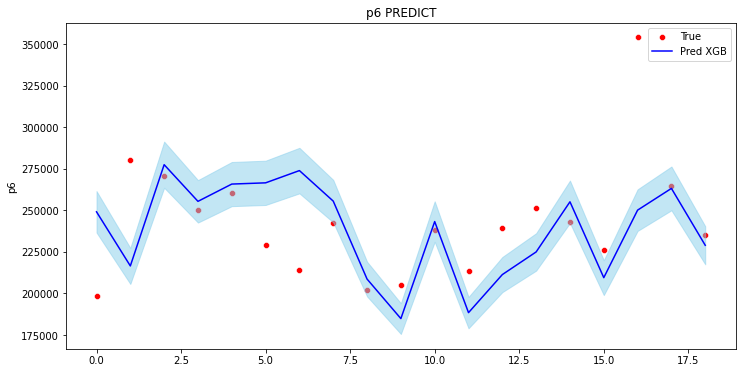

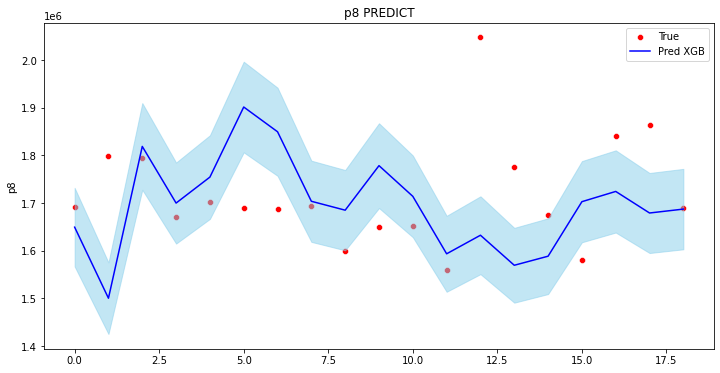

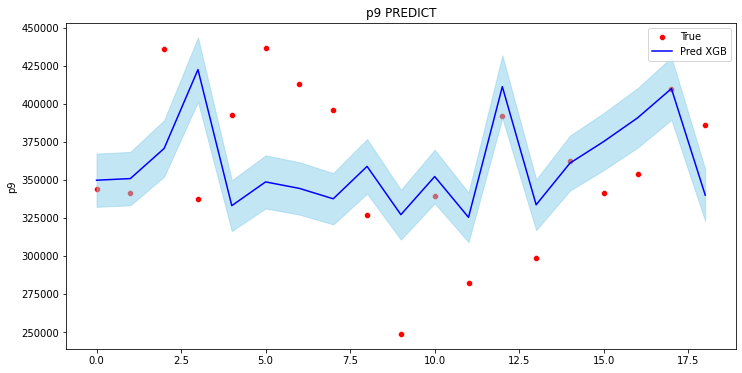

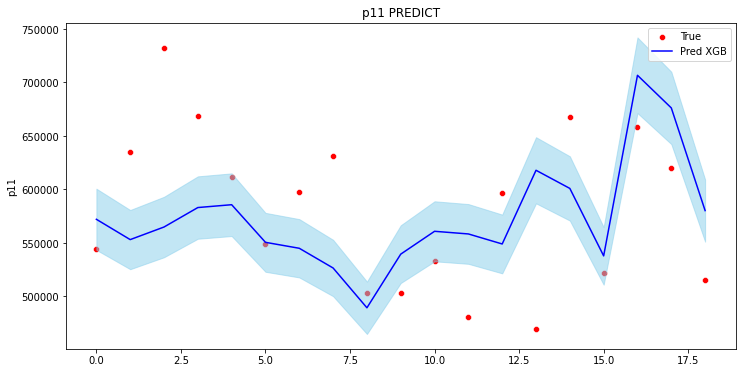

In [197]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

for col in ["p6","p8","p9","p11"]:

  lr = LinearRegression()
  xgb = XGBRegressor()

  test = concat_df.dropna(axis=0)

  x_col = ["p6","p8","p9","p11","q6","q8","q9","q11"]
  x_col.remove(col)

  X = test[x_col]
  y = test[col]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=52)

  lr.fit(X_train,y_train)
  xgb.fit(X_train, y_train)

  lr_pred = lr.predict(X_test)
  xgb_pred = xgb.predict(X_test)

  idx_x = [i for i in range(len(X_test))]

  plt.figure(figsize=(12,6))
  sns.scatterplot(x=idx_x, y = y_test, color='r' , label='True')
  # sns.lineplot(x=idx_x, y= lr_pred, color='g', label='Pred Linear')
  sns.lineplot(x=idx_x, y = xgb_pred, color='b', label='Pred XGB')

  plt.fill_between(idx_x, xgb_pred*1.05, xgb_pred*0.95, color='skyblue', alpha=.5)

  plt.title(str(col) + " PREDICT")
  plt.show()

가지고 있는 정보만으로는 가격 결측값 가격을 예측하기에는 어려움이 있어서 사용하지 않기로 결정함.

In [198]:
test_df = master_p.dropna(axis=0)

In [199]:
target_price = ticket_dfs[11][['unitPrice']].resample('1H').mean()
target_quantity = ticket_dfs[11][['quantity']].resample('1H').sum()

<AxesSubplot:xlabel='sold_Date', ylabel='unitPrice'>

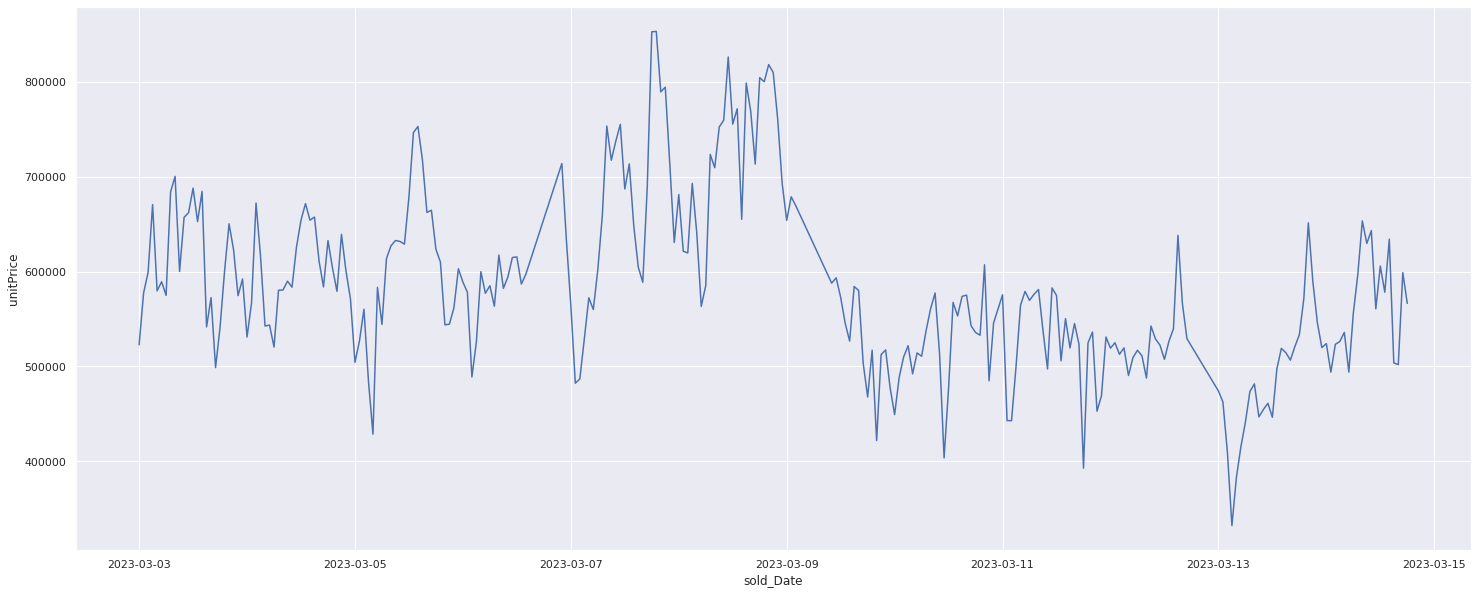

In [200]:
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(x=target_price.index , y=target_price['unitPrice'])

In [201]:
temp_df = target_price['2023-03-01 06:00:00':'2023-03-13 05:59:59']
tmp_df2 = target_quantity['2023-03-01 06:00:00':'2023-03-13 05:59:59']
study_df = pd.DataFrame()
study_df['ds'] = temp_df.reset_index(drop=False)['sold_Date']
study_df['y'] = temp_df.reset_index(drop=False)['unitPrice']
study_df['quantity'] = tmp_df2.reset_index(drop=False)['quantity']

In [245]:
from sklearn.model_selection import ParameterGrid

params_grid = {
    'changepoint_prior_scale' : [0.1,0.3,0.5,0.7],
    'seasonality_mode' : ['multiplicative' ,'additive'],
    'seasonality_prior_scale' : [8, 10, 12, 15, 17],
    'weekly_seasonality' : [8, 10, 12, 15, 17],
    'daily_seasonality' : [8, 10, 12, 15, 17]
}

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
  cnt +=1

print('Total Models ',cnt)

Total Models  1000


In [261]:
len(actual.dropna()), len(test['yhat'].loc[actual.dropna().index])

(262, 262)

In [248]:
len(actual), len(test['yhat'])

(283, 278)

In [264]:
MAPE

0.07061910270067026

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])

for p in grid:
  model = prophet.Prophet(
    changepoint_prior_scale = p['changepoint_prior_scale'],
    seasonality_mode = p['seasonality_mode'],
    seasonality_prior_scale = p['seasonality_prior_scale'],
    weekly_seasonality = p['weekly_seasonality'],
    daily_seasonality = p['daily_seasonality'],
    yearly_seasonality = False
  )
  
  model.fit(study_df)

  future = model.make_future_dataframe(periods=37, freq='H')

  forecast = model.predict(future)
  test = forecast[['ds','yhat']]
  actual = temp_df['unitPrice']
  MAPE = mean_absolute_percentage_error(actual.dropna(), abs(test['yhat'].loc[actual.dropna().index]))
  model_parameters = model_parameters.append({
      'MAPE' : MAPE,
      'Parameters' : p
  }, ignore_index = True)

In [269]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MAPE        1000 non-null   float64
 1   Parameters  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [280]:
parameters['Parameters'].loc[0]

{'changepoint_prior_scale': 0.1,
 'daily_seasonality': 12,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 12,
 'weekly_seasonality': 17}

DEBUG:cmdstanpy:input tempfile: /tmp/tmpilxurtq4/re5ofksm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpilxurtq4/l2x5owr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98892', 'data', 'file=/tmp/tmpilxurtq4/re5ofksm.json', 'init=/tmp/tmpilxurtq4/l2x5owr4.json', 'output', 'file=/tmp/tmpilxurtq4/prophet_modelinga05j3/prophet_model-20230314113418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


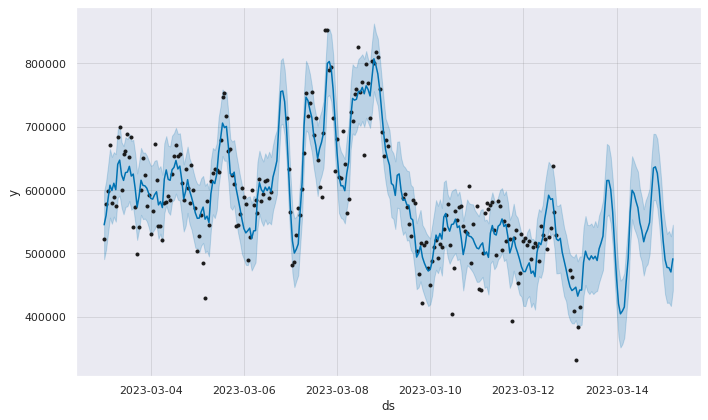

In [281]:
model = prophet.Prophet(
    changepoint_prior_scale = 0.1,
    seasonality_mode = 'multiplicative' ,
    seasonality_prior_scale = 12,
    weekly_seasonality = 17,
    daily_seasonality = 12,
    yearly_seasonality = False
)

model.fit(study_df)

future = model.make_future_dataframe(periods=48, freq='H')

forecast = model.predict(future)
fig = model.plot(forecast)

In [282]:
result = pd.DataFrame()
result = forecast[['yhat_lower','yhat_upper','yhat']]
temp_df = pd.DataFrame()
temp_df = target_price['2023-03-01 06:00:00':'2023-03-15 05:59:59']
result['real'] = temp_df['unitPrice'].reset_index(drop=True)
temp_df.reset_index(inplace=True)
result['sold_Date'] = forecast['ds']
# result.dropna(inplace=True)
result.set_index('sold_Date',drop=True,inplace=True)
result

,yhat_lower,yhat_upper,yhat,real
sold_Date,,,,
2023-03-03 00:00:00,490879,597878,545110,522778
2023-03-03 01:00:00,506200,613159,559785,577403
2023-03-03 02:00:00,531845,637535,585518,599238
2023-03-03 03:00:00,556435,664767,607621,670490
2023-03-03 04:00:00,546792,652364,599207,579665
...,...,...,...,...
2023-03-15 01:00:00,435432,547555,490139,NaN
2023-03-15 02:00:00,421845,530792,477830,NaN
2023-03-15 03:00:00,422354,535242,477296,NaN


In [283]:
gold_price = gold_price[gold_price.index >= target_price.index.min()]

In [301]:
def vsplot(df, xlim = ''):
  fig, ax = plt.subplots(2,1)
  sns.lineplot(df.index,df['yhat'], label='forecast data', color='blue', ax = ax[0])
  ax[0].fill_between(df.index,df['yhat_upper'],df['yhat_lower'],color='skyblue',label='80% confidence interval')
  ax[0].scatter(df.index,df['real'], label='Real data ', color='black')
  ax[0].vlines(pd.to_datetime('2023-03-13 06:00:00'),0,1000000, color="green", label = 'Predict Line')
  # sns.lineplot(x = target_price.index, y = target_price['unitPrice'], color = 'red', ax = ax[0])
  sns.lineplot(x = gold_price.index, y = gold_price['price'], color = 'orange', ax=ax[1], label = 'Gold Price')
  if xlim != '':
    ax[0].set_xlim(xlim)
  
  
  
  ax[0].legend()
  ax[0].set_title('Predict ticket Price')
  ax[1].legend()
  ax[1].set_title('Gold Price')
 
  ax[1].set_xlabel('sold_Date')

  plt.show()

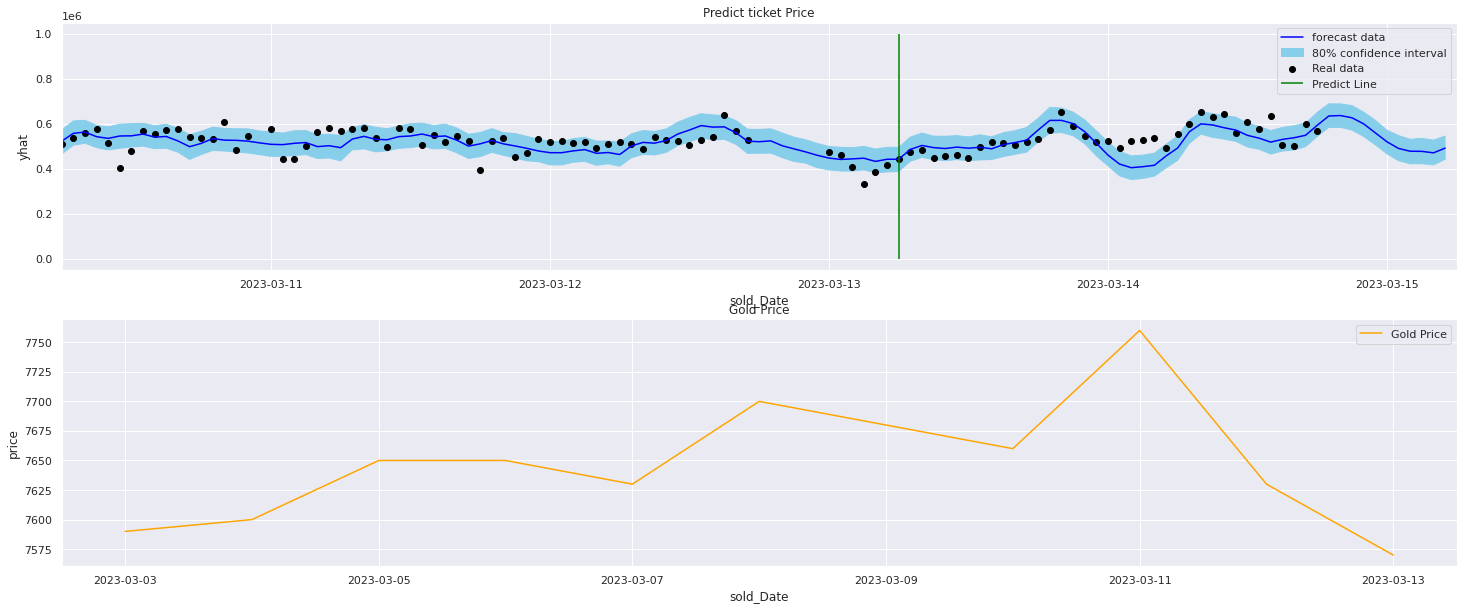

In [400]:
vsplot(result, [pd.to_datetime('2023-03-10 06:00'), pd.to_datetime('2023-03-15 06:00')])

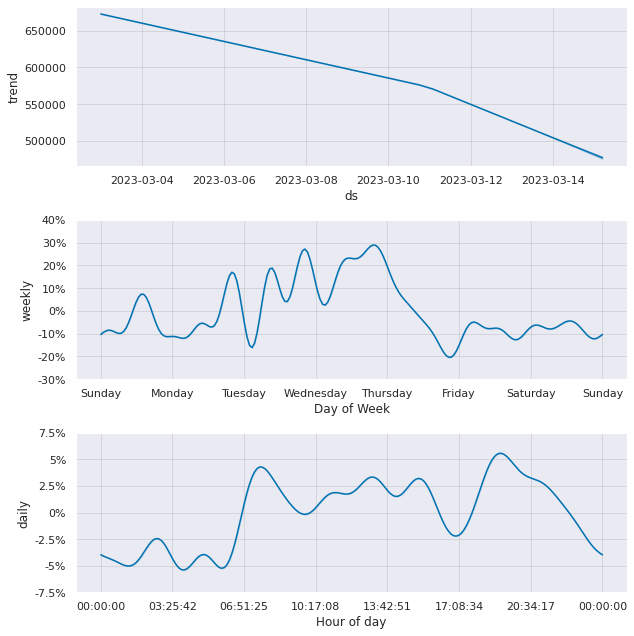

In [303]:
fig = model.plot_components(forecast)

In [366]:
regi_df = ticket_history.copy()

In [367]:
regi_df['itemName'] = regi_df['itemName'].apply(changeName)
regi_df = regi_df.drop(['auctionNo', 'itemCode', 'price'], axis=1)
regi_df['regDate'] = pd.to_datetime(regi_df['regDate'])
regi_df['quantity'] = regi_df['quantity'].astype(int)
regi_df['unitPrice'] = regi_df['unitPrice'].astype(int)

# 상급던전 마스터만 필터링
regi_df = regi_df[regi_df['itemName'].isin([6,8,9,11])]
regi_df = regi_df.set_index('regDate', drop=True)

In [368]:
regi_df.head()

,itemName,quantity,unitPrice,status
regDate,,,,
2023-03-01 04:47:54,11,1,549000,Saled
2023-03-01 04:38:41,11,1,549990,Saled
2023-03-01 04:25:35,11,3,569999,Saled
2023-03-01 04:22:46,11,1,600000,Saled
2023-03-01 04:14:26,11,1,580000,Saled


In [369]:
regi_df[regi_df['itemName']==11]['status'].value_counts()

Saled     13986
Saling      383
Name: status, dtype: int64

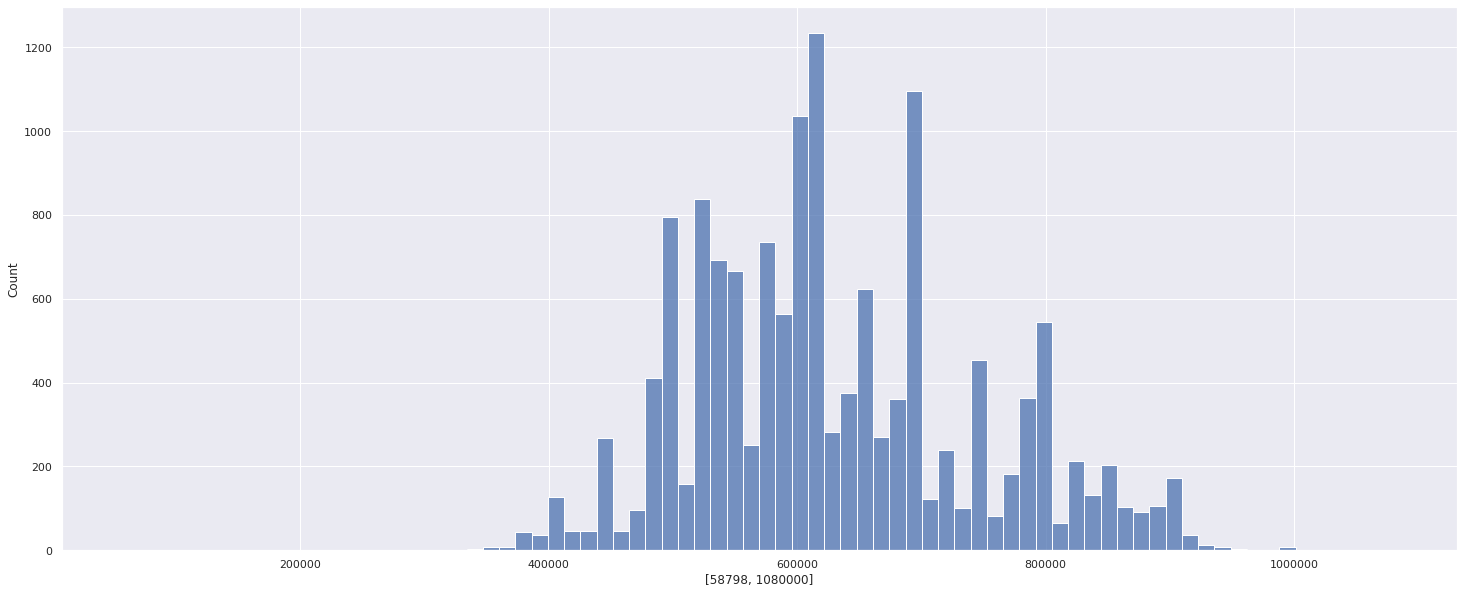

In [376]:
target = regi_df[regi_df['itemName']==11]
sns.histplot(target['unitPrice'])
plt.xlabel([target['unitPrice'].min(), target['unitPrice'].max()])
plt.ticklabel_format(axis='x',useOffset=False, style='plain')

58798 1000000


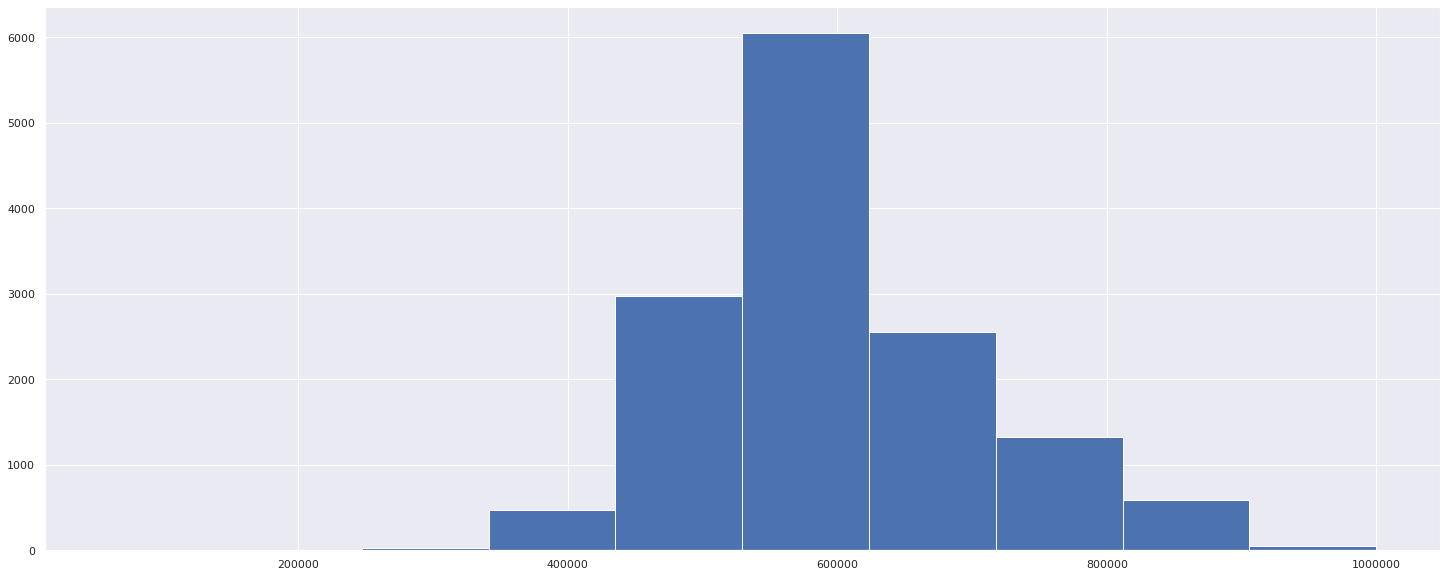

In [389]:
target = master_prices[master_prices['itemName']==11]['unitPrice']
target.hist()
plt.ticklabel_format(axis='x',useOffset=False, style='plain')
print(target.min(), target.max())

아이템 등록 기록의 경우 두 가지 문제점이 있음.
- 경매장 아이템의 등록 기간은 3일로 거래가 이뤄지지 않아도 경매장에서 사라짐. 그렇기 때문에 가격이 높은 이상 데이터의 경우 구매가 됐는지 판매가 됐는지 알 수 없음
- 경매장에 아이템을 등록했으나 등록을 취소한 경우도 경매장에서 목록에서 사라진것으로 판매처리되었음.

이러한 두 가지 때문에 경매자 거래 내역과 비교 해봐야함.
우선 **첫번째** 문제점의 경우 등록된 가격의 분포와 판매된 가격의 분포를 비교해보고 둘이 차이가 있는지 살펴본다. 특히 각 그룹의 최대값을 비교하여 거래가 이뤄진게 맞는지 확인한다. 만약 거래가 이뤄졌다면 해당 아이템에 대한 수요가 충분히 있기 때문에 해당 가격에도 거래가 되고 있다고 판단한다.
**두번째** 거래량 자체를 비교하고 취소 혹은 등록기간이 만료됐다고 생각되는 물픔의 수량을 확인하고 무시할만한 수준인지 확인한다.

</br></br>
**결과**</br>
1. 경매장에 등록된 가격과 판매된 가격의 분포가 비슷한 분포를 갖고 있음. 가장 우려했던 최대가격에 대한 거래는 판매기록에도 같은 가격으로 있었고 이는 해당 아이템에 대한 수요가 이상치로 보이는 가격에도 거래될 정도로 있다고 보였다.

2. 


In [337]:
regi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19298 entries, 0 to 19297
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   regDate    19298 non-null  datetime64[ns]
 1   itemName   19298 non-null  int64         
 2   quantity   19298 non-null  int64         
 3   unitPrice  19298 non-null  object        
 4   status     19298 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 754.0+ KB


In [390]:
regi_item_11 = regi_df[regi_df['itemName']==11]
sold_item_11 = master_prices[master_prices['itemName']==11]

In [396]:
len(regi_item_11), len(sold_item_11), len(regi_item_11)-len(sold_item_11)

(14369, 14048, 321)

In [395]:
regi_item_11['status'].value_counts()

Saled     13986
Saling      383
Name: status, dtype: int64

판매 완료 기록과 등록기록의 차이는 62개로 전체 등록 매물중 0.4%였다.